In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [48]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['compositional-abstractions']
coll = db['two-towers']

# which iteration name should we use?
iterationName = 'pilot2'

## look up number of trials
trialNumDict = {'testing':13, 'pilot2':13}
numTrials = trialNumDict[iterationName]

### construct tidy dataframe with game data

### establish connection to mongo
First thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

`ssh -fNL 27017:127.0.0.1:27017 USERNAME@cogtoolslab.org`

In [49]:
## get list of all gameIDs in database
total_games = coll.find({'iterationName':iterationName}).distinct('gameid')
print('There are {} total games.'.format(len(total_games)))

## get list of complete gameIDs
gameIDs = coll.find({'iterationName':iterationName}).distinct('gameid')
complete_games = [g for g in gameIDs if len(coll.find({'gameid':g}).distinct('trialNum')) == numTrials]
print('There are {} complete games.'.format(len(complete_games)))

There are 1 total games.
There are 0 complete games.


In [50]:
broken_games = []
complete_games = [g for g in complete_games if g not in broken_games]

def construct_tidy_dataframe(eventType = 'chatMessage', 
                             complete_games = [],
                             iterationName = 'pilot1',
                             remove_workerID = True):
    '''
    input: list of complete games and name of event Type
    '''
    event2name = {'chatMessage':'chat', 'block':'block', 'endTrial':'trial', 'exitSurvey':'exit'}
    L = pd.DataFrame()
    for g, this_gameID in enumerate(complete_games):
        print('Analyzing game {} | {} of {}'.format(this_gameID, g+1, len(complete_games)))
        clear_output(wait=True) 

        ### extract records 
        #loop over iteration names??
        X = coll.find({ '$and': [{'iterationName':iterationName}, 
#                                  {"$or":[{'iterationName':'Exp2Pilot3'},
#                                  {'iterationName':'Exp2Pilot3_batch2'}]}
                                 {'gameid': this_gameID}, {'eventType': eventType}]}).sort('time') 
        
        li = list(X)        
        _L = pd.DataFrame(li)  

        ## concat with previous game's dataframe
        if L.shape[0]==0:
            L = _L
        else: 
            L = pd.concat([L,_L], axis=0)     

    ## postprocessing
    if remove_workerID and 'workerId' in L.columns:
        L = L.drop('workerId',axis=1)

    ## save out group dataframe to csv dir
    out_path = os.path.join(csv_dir,'compabs_{}_{}.csv'.format(event2name[eventType],iterationName))
    print('Saving dataframe out to CSV dir at path: {}'.format(out_path))    
    L.to_csv(out_path)             

    return L


In [51]:
## construct dataframe for each datatype
dataTypes = coll.distinct('eventType')
for thisDataType in dataTypes:
    X = construct_tidy_dataframe(eventType=thisDataType, complete_games=complete_games, iterationName=iterationName)


Saving dataframe out to CSV dir at path: /Users/choldawa/Documents/Projects/composition-abstractions/results/csv/compabs_chat_pilot2.csv
Saving dataframe out to CSV dir at path: /Users/choldawa/Documents/Projects/composition-abstractions/results/csv/compabs_block_pilot2.csv
Saving dataframe out to CSV dir at path: /Users/choldawa/Documents/Projects/composition-abstractions/results/csv/compabs_trial_pilot2.csv
Saving dataframe out to CSV dir at path: /Users/choldawa/Documents/Projects/composition-abstractions/results/csv/compabs_exit_pilot2.csv


## Full DF from DB

In [7]:
# Ensure one to one gameID and workerId 
# Should only happen if a repeat worker gets through

# query = coll.find({"$and":[
# #                         {'workerId':{'$exists':True}},
# #                         {'condition':{'$ne':'practice'}},
# #                         {'eventType':'trial_end'},
#                         {"$or":[{'iterationName':'testing'}]}]
#                      })

#df_trial_end_full = pd.DataFrame(list(query.sort('timeAbsolute')))
#df_trial_end_full[['workerId','gameID']]

query = coll.find()

df_trial_end_full = pd.DataFrame(list(query))

#assert (np.mean(df_trial_end_full['workerId'].value_counts()) == np.mean(df_trial_end_full['gameID'].value_counts()))

In [8]:
## How many records?
coll.estimated_document_count()

3485

In [9]:
#df_trial_end_full.columns

#### check outcome for specific workerID

In [53]:
#set worker ID
workerID = 'A37XBH865833FE'
iteration = 'pilot0'
#get GameID (not all info available at workerID level (e.g. bonus))
gameID = df_trial_end_full[df_trial_end_full['workerId'] == workerID]['gameid'].unique()[0]

#check iteration name
df_game = df_trial_end_full[(df_trial_end_full['iterationName'] == iteration) &
                            (df_trial_end_full['gameid'] == gameID)]
#get workerIds
print('workerIDS:',df_game['workerId'].unique())
#get bonus for gameID ([air of workerIDs])
print("Bonus:",np.nanmax(df_game['cumulativeBonus']))

workerIDS: ['A37XBH865833FE' 'AT6LDQNLKTUSE']
Bonus: 0.84


In [57]:
df_trial_end_full[(df_trial_end_full['iterationName'] == 'pilot1')].content.unique()

array(['Place the blue blocks directly over the red tick mark on the left of the screen~~~',
       nan,
       'Place the red blocks just to the left of the red tick mark on the right side',
       'Place two blue blocks so they meet in the middle over the mark on the left side~~~',
       'Place two red blocks so they form a right angle on the blue blocks - and L',
       'Block on the far left of the placed blue blocks - build up from there with two red ones stacked',
       "This time we're making an upside down U - red blocks one count over from the red tick on the right s",
       'Ok - one red block to the right of the one you placed on the baseline~~~',
       'now count two blocks over from the first red one you placed adn put one red block',
       "Right side red tick mark - put one blue block so it's centered\n",
       'Now from the left blue block, place two red blocks above so it goes up',
       'Now place a blue block on top of the red so it mirrors the one below',
   

In [12]:
#see full history for single worker
df_test = df_trial_end_full[(df_trial_end_full['iterationName'] == iterationName)&
                           (df_trial_end_full['workerId'] == workerID)]
df_test.content.unique()

array(['place one column 3 row 1', nan,
       'place blue block flat and two away from right side\n',
       'place red blacks upright and 2 to the right \n',
       'place blue 1 to the right and flat',
       'place blue next to the previous one and a red on top of the first',
       'place another red on top of the previous red',
       'place one red 1 to the left of the far right',
       'place another red 2 to the left of the first red and then connect the two with blues',
       'place a red 3 to the left of first red ',
       'place blue 3 to the right on left side',
       'place red above blue and 1 to the left',
       'place 1 red 1 to the left of the far right ',
       'place one blue one to the left of the far right above the red going leftward',
       'place another blue next to the previous blue going leftward',
       'place a blue next to the blue that is above the red blocks going leftward',
       'do that again but above the previous',
       'place blue 1 to 

## Trial Level Data

In [13]:
# # Assuming that if trial 23 saves, then 0-22 have also saved 
# # get ids of people with trial 23 data
# query = coll.find({"$and":[
#                         {'condition':{'$ne':'practice'}},
#                         {'eventType':'trial_end'},
#                         {"$or":[{'iterationName':'Exp2Pilot3'},
#                                 {'iterationName':'Exp2Pilot3_batch2'}]},
#                         #{'iterationName': iterationName}, #use this if one iteration name
#                         {'trialNum': numTrials-1}]
#                      })
# complete_data_df = pd.DataFrame(query)
# complete_data_ids = list(complete_data_df['workerId'])

In [14]:
# # Filter for full datasets
# query = coll.find({"$and":[
#                         {'condition':{'$ne':'practice'}},
#                         {'eventType':'trial_end'},
#                         #{'iterationName': iterationName}, #use this if one iteration name
#                         {"$or":[{'iterationName':'Exp2Pilot3'},
#                                 {'iterationName':'Exp2Pilot3_batch2'}]}]
#                      })

# df_trial_end_full = pd.DataFrame(list(query.sort('timeAbsolute')))


# # filter dataframe for complete datasets
# df_trial_end_full_filtered = df_trial_end_full[df_trial_end_full.workerId.isin(complete_data_ids)]

# # reduce to crucial information
# df_trial_end_reduced_filtered = df_trial_end_full_filtered[[
#     'gameID','trialNum','phase','condition','eventType','targetName','repetition','targetID', #trial identifiers
#     'nullScore','F1Score','normedScore','rawScoreDiscrete','nullScoreDiscrete','normedScoreDiscrete','scoreGapDiscrete', #scoring
#     'numBlocks','nPracticeAttempts','blockColor','blockColorID','blockFell','doNothingRepeats',#misc. trial info
#     'score','currBonus','timeBonus', #bonusing
#     'timeAbsolute','timeRelative','buildTime','buildStartTime','buildFinishTime','timeToBuild', #timing 
#     'discreteWorld','allVertices', #world reconstruction
#     'browser','browserVersion','os','devMode', #developer info
#     #below here should be the same for every trial in a dataset
#     'iterationName',
#     'numTargets', 'prePostSetSize','numRepetitions', #pre-post info
#     'bonusThresholdLow','bonusThresholdMid','bonusThresholdHigh','timeThresholdYellow','timeThresholdRed', #bonus info
#     ]]

# #Fix error in data-saving- normedScoreDiscrete saved as rawScoreDiscrete
# df_trial_end_reduced_filtered['normedScoreDiscrete'] = df_trial_end_reduced_filtered['rawScoreDiscrete']
# df_trial_end_reduced_filtered.drop(['rawScoreDiscrete'], axis=1)


# df = df_trial_end_reduced_filtered.sort_values(by=['gameID', 'timeAbsolute'])

## Create DF for each event

In [59]:
#read in dataframes from each eventType
df_block = pd.read_csv('../results/csv/compabs_block_{}.csv'.format(iterationName))
df_chat = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format(iterationName))
df_exit = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format(iterationName))
df_trial = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format(iterationName))

#### Total Game Duration (for Gameplay)

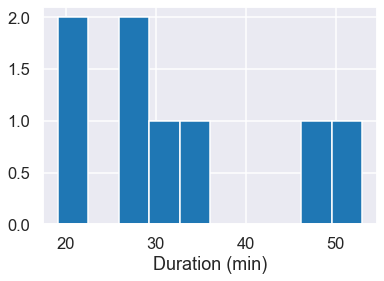

In [16]:
(df_exit.groupby(['gameid'])['totalLength'].max()/60000).hist()
plt.xlabel("Duration (min)")
plt.show()

### Inspect some raw data: language

In [17]:
#create columns for char and word counts
df_chat['word_count'] = df_chat['content'].str.split(' ').str.len()
df_chat['char_count'] = df_chat['content'].str.len()

In [18]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_chat['trialNum'] = pd.to_numeric(df_chat['trialNum'], errors = 'coerce')

In [19]:
df_chat['content'].unique()

array(['place the red one 3 from the left and the blue 3 from the right',
       'close, but put the towers starting on the third blocks from each side\n',
       'put a blue block three from the left~~~ ',
       'place a red block on top of the left side of the blue block and then another red on top of that red',
       'Now place a blue block on top of that that lines up with the bottom blue block',
       'remove that last blue block, place it on top of the red blocks',
       'place a red block on the second grid from the right of the screen\n',
       'now place another red block three more space to the left of that one',
       'place two blue blocks next to each other connecting on top of the two red blocks\n',
       'place a blue block starting in the second grid from the left',
       'place another blue block directly to the right of it\n',
       'stack two red blocks on top of eachother on the left side of the first blue block',
       'place a blue block starting in the 

### Inspect some raw data: display block towers

In [20]:
importlib.reload(drawing)
df_block['w'] = df_block['width']
df_block['h'] = df_block['height']

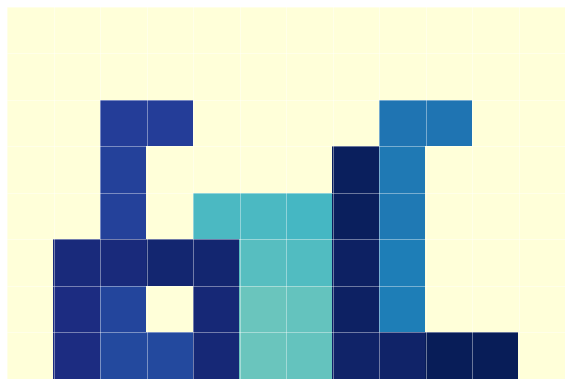

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
drawing.draw_from_actions_subplot(df_block[df_block.trialNum=='11'], 
                                  ax, 
                                  world_size = [12,8])

## Make basic visualizations and calculate descriptives

### Architect: mean number of words across trials

In [22]:
#Get sum of words for each trial, group by game then average across games
print(df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean())

trialNum
0.0     69.375
1.0     60.625
2.0     46.250
3.0     39.750
4.0     38.000
5.0     28.500
6.0     21.750
7.0     19.375
8.0     17.875
9.0     19.625
10.0    19.125
11.0    18.125
Name: word_count, dtype: float64


Text(0, 0.5, 'Word Count')

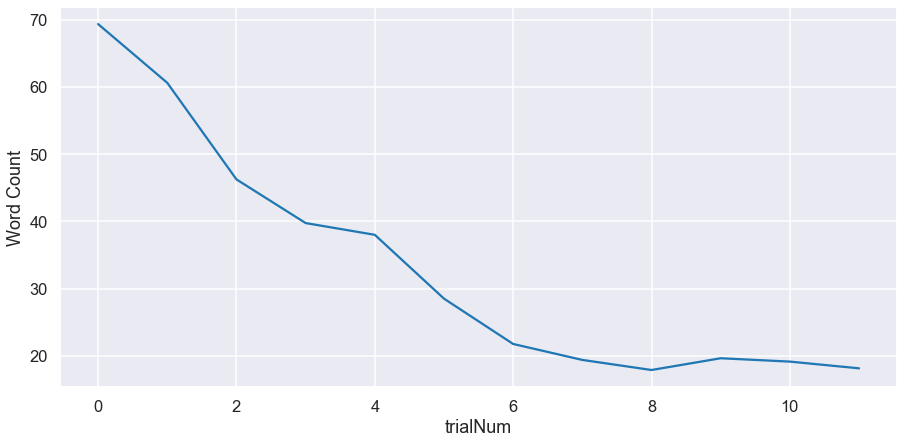

In [23]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Word Count')

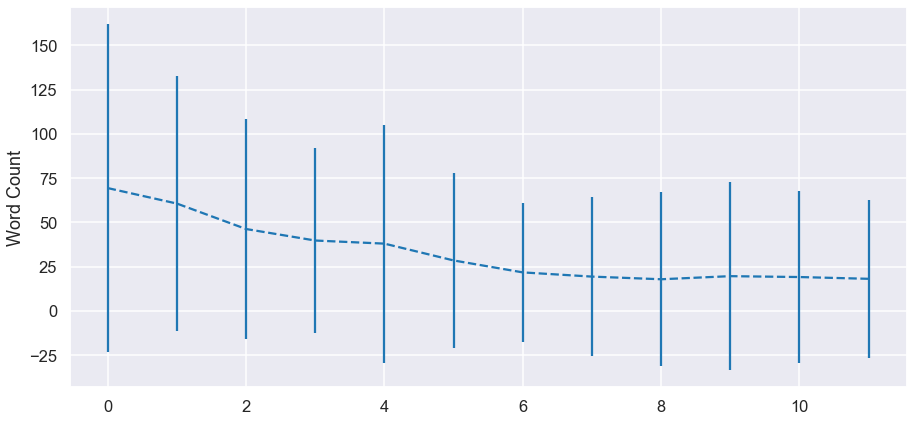

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
mean = df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean()
std = df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).std()

plt.errorbar(mean.index, mean, yerr=2*std, linestyle='--')
plt.ylabel('Word Count')
plt.show()

In [25]:
## print summary stat to console?

###  Architect: mean number of characters across trials

Text(0, 0.5, 'Char Count')

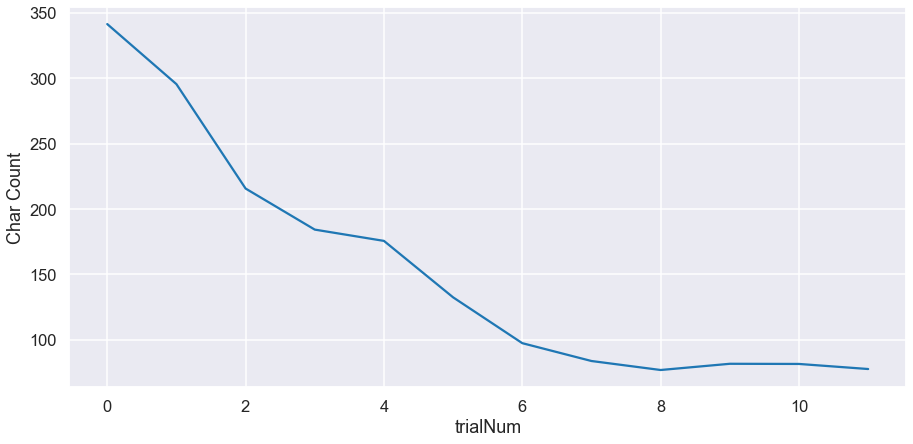

In [26]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['char_count'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Char Count')

### Architect: mean number of messages (across turns within a trial) across trials

Text(0, 0.5, 'Messages per trial')

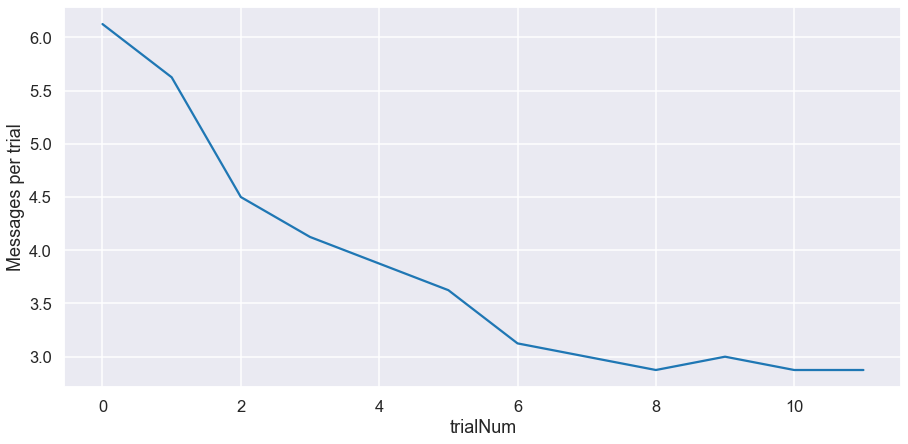

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['_id'].count().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Messages per trial')

### Architect: Total typing time (across turns within at trial) across trials

In [28]:
#check time elapsed
df_chat["timeElapsedInTurn"] = pd.to_numeric(df_chat['timeElapsedInTurn'])

Text(0, 0.5, 'Average Time elapsed, Architect')

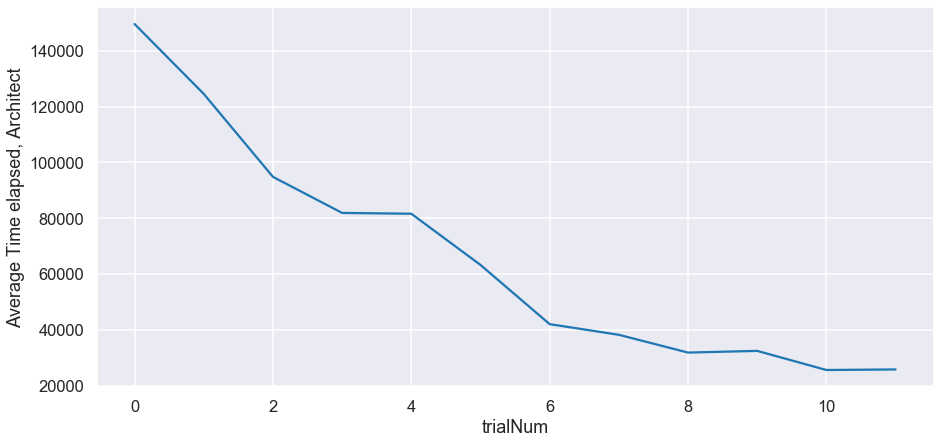

In [29]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Architect')

In [30]:
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean()

trialNum
0.0     149540.125
1.0     124506.000
2.0      94790.250
3.0      81865.375
4.0      81575.000
5.0      63230.625
6.0      42002.750
7.0      38194.875
8.0      31824.875
9.0      32425.750
10.0     25576.375
11.0     25776.875
Name: timeElapsedInTurn, dtype: float64

### Builder: Reconstruction accuracy (intersection over union, IOU) across trials

In [31]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_trial['trialNum'] = pd.to_numeric(df_trial['trialNum'], errors = 'coerce')
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_block['trialNum'] = pd.to_numeric(df_block['trialNum'], errors = 'coerce')

In [32]:
df_trial.head()

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,repNum,trialScore,cumulativeScore,cumulativeBonus,eventType
0,0,5ef783a1ce2f7f58fcd0a354,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,practice,25,0,0.00,endTrial
1,1,5ef783c3ce2f7f58fcd0a35b,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,practice,100,0,0.00,endTrial
2,2,5ef784d6ce2f7f58fcd0a3a0,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,Pi,0.0,0,0,87,87,0.06,endTrial
3,3,5ef7859cce2f7f58fcd0a3d3,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,L,C,1.0,0,0,100,187,0.16,endTrial
4,4,5ef7863ece2f7f58fcd0a405,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,L,Pi,2.0,0,0,87,274,0.22,endTrial


Text(0, 0.5, 'Trial Score')

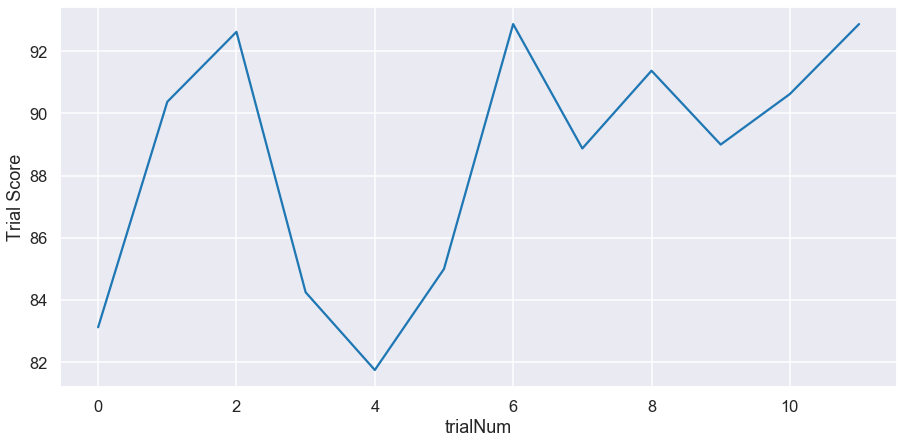

In [33]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['gameid','trialNum'])['trialScore'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Trial Score')

### Architect: Distribution of words over trials

### Builder: Distribution of blocks placed per utterance


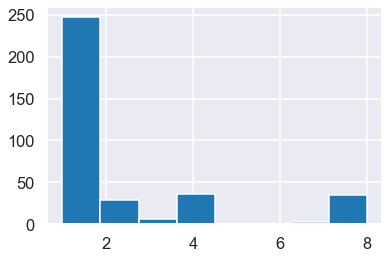

In [35]:
(df_block.groupby(['gameid','trialNum', 'turnNum'])['_id'].count()).hist(bins = 8)
plt.show()


### Builder: Total reconstruction time (summed build time across turns, within each trial) across trials

In [36]:
#check time elapsed
df_block["timeElapsedInTurn"] = pd.to_numeric(df_block['timeElapsedInTurn'])

In [37]:
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum()

gameid                                     trialNum
1494-029e2297-bd3f-4cfe-be00-d06d36724e4e  0.0         106131
                                           1.0          84608
                                           2.0         148591
                                           3.0         183137
                                           4.0         230111
                                                        ...  
9387-db1af5ad-b089-48ad-a730-baee40f08177  7.0         192470
                                           8.0         148768
                                           9.0         136153
                                           10.0        138547
                                           11.0        100666
Name: timeElapsedInTurn, Length: 96, dtype: int64

Text(0, 0.5, 'Average Time elapsed, Builder')

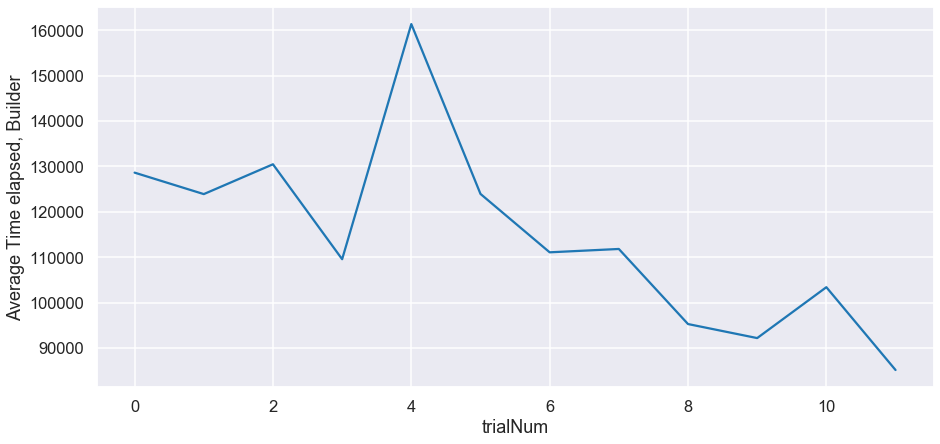

In [38]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Builder')

### Now, let's look at the DVs above, w.r.t. repetition of scenes, IGNORING which side a tower appears on... so across four repetitions (where [A,B] is equivalent to [B,A])

#### use rep num

In [39]:
#
def convert(list): 
    return tuple(i for i in list)
df_chat['targetSet'] = convert(df_chat[['leftTarget', 'rightTarget']].values.tolist())

In [40]:
df_chat.head(2)

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,repNum,content,timeElapsedInTurn,timeElapsedInTrial,eventType,word_count,char_count,targetSet
0,0,5ef78389ce2f7f58fcd0a350,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,practice,place the red one 3 from the left and the blue...,60567,60567,chatMessage,15,63,"(vertical, horizontal)"
1,1,5ef783bace2f7f58fcd0a358,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,practice,"close, but put the towers starting on the thir...",20018,20018,chatMessage,13,70,"(vertical, horizontal)"


In [41]:
print(df_chat.groupby(['gameid','trialNum','repNum'])['word_count'].sum())

gameid                                     trialNum  repNum
1494-029e2297-bd3f-4cfe-be00-d06d36724e4e  0.0       0         106
                                           1.0       0          88
                                           2.0       0          58
                                           3.0       1          42
                                           4.0       1          29
                                                              ... 
9387-db1af5ad-b089-48ad-a730-baee40f08177  7.0       2           1
                                           8.0       2           1
                                           9.0       3           1
                                           10.0      3           1
                                           11.0      3           1
Name: word_count, Length: 96, dtype: int64


Text(0, 0.5, 'Words Per figure')

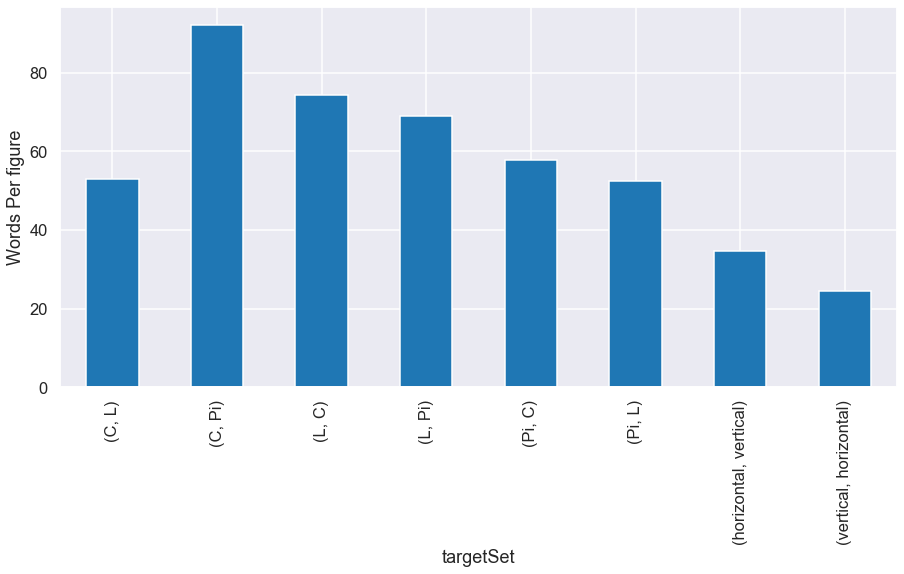

In [42]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','targetSet'])['word_count'].sum().groupby(['targetSet']).mean().plot.bar(ax = ax)
plt.ylabel('Words Per figure')